<a href="https://www.kaggle.com/code/tranlemylinh/absa-vietnamese?scriptVersionId=181058259" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# DATA

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import re


# Load dataset



In [3]:

# Đường dẫn tới các file
TRAIN_PATH ='/kaggle/input/absa-nlp/train.csv'
VAL_PATH ='/kaggle/input/absa-nlp/val.csv'
TEST_PATH ='/kaggle/input/absa-nlp/test.csv'

# Đọc các file CSV
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

# Lấy tất cả các tên cột từ cả ba DataFrame
all_columns = set(train_df.columns).union(set(val_df.columns)).union(set(test_df.columns))

all_columns

{'FACILITY', 'LECTURER', 'OTHERS', 'Sentence', 'TRAINING_PROGRAM'}

# Preprocess data

In [4]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00


In [5]:
import regex as re
import string
import emoji

from nltk import flatten
import unicodedata
from underthesea import word_tokenize


In [6]:
# 1. Loại bỏ các thẻ HTML
def remove_HTML(text):
    clean = re.compile('<.*?>')
    return re.sub(clean,'', text)

# 2. Chuyển đổi các ký tự Unicode về dạng chuẩn
def convert_unicode(text):
    return unicodedata.normalize('NFC', text)

# 3. Loại bỏ các ký tự kéo dài
def remove_elongated_chars(text):
    replacements = {
       'a':'àáảãạăằắẳẵặâầấẩẫậ',
       'e':'èéẻẽẹêềếểễệ',
       'i':'ìíỉĩị',
       'o':'òóỏõọôồốổỗộơờớởỡợ',
       'u':'ùúủũụưừứửữự',
       'y':'ỳýỷỹỵ',
       'd':'đ',
       'A':'ÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬ',
       'E':'ÈÉẺẼẸÊỀẾỂỄỆ',
       'I':'ÌÍỈĨỊ',
       'O':'ÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢ',
       'U':'ÙÚỦŨỤƯỪỨỬỮỰ',
       'Y':'ỲÝỶỸỴ',
       'D':'Đ'
    }
    
    for char, replacements_str in replacements.items():
        pattern = rf"({char})\1+"
        text = re.sub(pattern, char, text)
    
    pattern = r"(\w)\1+"
    text = re.sub(pattern, r'\1', text)
    return text

# 4. Xử lý các từ phủ định
def handle_negation(text):
    not_words = {"không",'không hề', "chẳng", "chưa", "không phải", "chả", "mất",
                 "thiếu", "đếch", "đéo", "kém", "nỏ", "not",
                 "bớt", "không bao giờ", "chưa bao giờ"}
    not_words = sorted(not_words, key=len, reverse=True)
    pattern = r'\b(?:'+'|'.join(re.escape(word) for word in not_words) + r')\b'
    text = re.sub(pattern,'không', text, flags=re.IGNORECASE)
    return text

# 5. Chuẩn hóa các từ viết tắt thường gặp
def normalize_acronyms(text):
    acronyms = {
       'ô kêi':'ok','okie':'ok','o kê':'ok',
       'okey':'ok','ôkê':'ok','oki':'ok','oke': 'ok','okay':'ok','okê':'ok',
       'tks': u'cám ơn','thks': u'cám ơn','thanks': u'cám ơn','ths': u'cám ơn','thank': u'cám ơn',
       '⭐':'star','*':'star','🌟':'star',
       'kg': u'không','not': u'không', u'kg': u'không','"k': u'không','kh':u'không','kô':u'không','hok':u'không','kp': u'không phải',u'kô': u'không','"ko': u'không', u'ko': u'không', u'k': u'không','khong': u'không', u'hok': u'không',
       'cute': u'dễ thương','vs': u'với','wa':'quá','wá': u'quá','j': u'gì','“':'',
       'sz': u'cỡ','size': u'cỡ', u'đx': u'được','dk': u'được','dc': u'được','đk': u'được',
       'đc': u'được','authentic': u'chuẩn chính hãng',u'aut': u'chuẩn chính hãng', u'auth': u'chuẩn chính hãng','store': u'cửa hàng',
       'shop': u'cửa hàng','sp': u'sản phẩm','gud': u'tốt','god': u'tốt','wel done':'tốt','good': u'tốt','gút': u'tốt',
       'sấu': u'xấu','gut': u'tốt', u'tot': u'tốt', u'nice': u'tốt','perfect':'rất tốt','bt': u'bình thường',
       'time': u'thời gian','qá': u'quá', u'ship': u'giao hàng', u'm': u'mình', u'mik': u'mình',
       'ể':'ể','product':'sản phẩm','quality':'chất lượng','chat':'chất','excelent':'hoàn hảo','bad':'tệ','fresh':'tươi','sad':'tệ',
       'date': u'hạn sử dụng','hsd': u'hạn sử dụng','quickly': u'nhanh','quick': u'nhanh','fast': u'nhanh','delivery': u'giao hàng',u'síp': u'giao hàng',
       'beautiful': u'đẹp tuyệt vời', u'tl': u'trả lời', u'r': u'rồi', u'shopE': u'cửa hàng',u'order': u'đặt hàng',
       'chất lg': u'chất lượng',u'sd': u'sử dụng',u'dt': u'điện thoại',u'nt': u'nhắn tin',u'tl': u'trả lời',u'sài': u'xài',u'bjo':u'bao giờ',
       'thick': u'thích','thik': u'thích', u'sop': u'cửa hàng', u'shop': u'cửa hàng', 
       'fb':'facebook','face':'facebook','very': u'rất',u'quả ng':u'quảng ',
       'dep': u'đẹp',u'xau': u'xấu','delicious': u'ngon', u'hàg': u'hàng', u'qủa': u'quả',
       'iu': u'yêu','fake': u'giả mạo','trl':'trả lời',
       'por': u'tệ','poor': u'tệ','ib':u'nhắn tin','rep':u'trả lời',u'fback':'feedback','fedback':'feedback',
       'max': u'cực kỳ',
       'full':'đầy đủ', 'ful':'đầy đủ'
    }
    words = text.split()
    normalized_text =' '.join([acronyms.get(word.lower(), word) for word in words])
    return normalized_text

# 6. Phân đoạn từ cho tiếng Việt
def word_segmentation(text):
    return word_tokenize(text, format="text")

# 7. Loại bỏ các ký tự không cần thiết khỏi văn bản
def remove_unnecessary_characters(text):
    text = re.sub(r'\s+', ' ', text)  # Loại bỏ khoảng trắng thừa
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ các ký tự đặc biệt
    return text.strip()

# 8. Kết hợp các hàm để tiền xử lý văn bản
def text_preprocess(text):
    text = remove_HTML(text)
    text = normalize_acronyms(text)
    text = convert_unicode(text)
    text = remove_elongated_chars(text)
    text = handle_negation(text)
    #text = word_segmentation(text)
    text = remove_unnecessary_characters(text)
    return text

In [7]:
!pip install tf-models-official


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 89.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.4 M

In [8]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from official.nlp import optimization


In [9]:
# Define pre-trained model and tokenizer
PRETRAINED_MODEL = 'vinai/phobert-base'  # Choose your preferred Vietnamese BERT model
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [10]:
# Prepare data for TensorFlow
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
BATCH_SIZE = 16


In [11]:
import numpy as np

In [12]:
"""def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if sentiment == 0: one_hot = [1, 0, 0, 0] #None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')
y_train = make_outputs(train_df)
y_val = make_outputs(val_df)
y_test = make_outputs(test_df)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]"""

"def make_outputs(df):\n    outputs = []\n    for row in range(len(df)):\n        row_one_hot = []\n        for col in range(1, len(df.columns)):\n            sentiment = df.iloc[row, col]\n            if sentiment == 0: one_hot = [1, 0, 0, 0] #None\n            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos\n            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg\n            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu\n            row_one_hot.append(one_hot)\n        outputs.append(row_one_hot)\n    return np.array(outputs, dtype='uint8')\ny_train = make_outputs(train_df)\ny_val = make_outputs(val_df)\ny_test = make_outputs(test_df)\n\nprint('Train outputs:', y_train.shape)\nprint('Validate outputs:', y_val.shape)\nprint('Test outputs:', y_test.shape)\ny_train[0]"

In [13]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if sentiment == 1:
                one_hot = [1, 0, 0]  # Positive
            elif sentiment == 2:
                one_hot = [0, 1, 0]  # Negative
            elif sentiment == 3:
                one_hot = [0, 0, 1]  # Neutral
            else:
                one_hot = [0, 0, 0]  # Skip None sentiment
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')
y_train = make_outputs(train_df)
y_val = make_outputs(val_df)
y_test = make_outputs(test_df)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[2]

Train outputs: (11426, 4, 3)
Validate outputs: (1583, 4, 3)
Test outputs: (3166, 4, 3)


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [14]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'FACILITY', 'LECTURER', 'OTHERS', 'TRAINING_PROGRAM'],
        num_rows: 11426
    })
    val: Dataset({
        features: ['Sentence', 'FACILITY', 'LECTURER', 'OTHERS', 'TRAINING_PROGRAM'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['Sentence', 'FACILITY', 'LECTURER', 'OTHERS', 'TRAINING_PROGRAM'],
        num_rows: 3166
    })
})

In [15]:
print('input_ids of sentence 1484:', raw_datasets['train'][1484])

input_ids of sentence 1484: {'Sentence': 'thầy tận tâm với học sinh  nhiệt tình với học sinh ', 'FACILITY': 0, 'LECTURER': 1, 'OTHERS': 0, 'TRAINING_PROGRAM': 0}


In [16]:
def tokenize_function(dataset):
    clean_texts = list(map(text_preprocess, dataset['Sentence']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [17]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

input_ids of sentence 1484: [0, 1249, 1855, 2652, 15, 222, 418, 2515, 939, 15, 222, 418, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
print('Decode:', tokenizer.decode(tokenized_datasets['train'][1484]['input_ids']))


Decode: <s> thầy tận tâm với học sinh nhiệt tình với học sinh </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [19]:
tokenized_datasets['train']

Dataset({
    features: ['Sentence', 'FACILITY', 'LECTURER', 'OTHERS', 'TRAINING_PROGRAM', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11426
})

In [20]:
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"], batch_size=BATCH_SIZE, shuffle=True
)

validation_dataset = tokenized_datasets["val"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"], batch_size=BATCH_SIZE, shuffle=True
)

In [21]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, GlobalAveragePooling1D


In [22]:
topic = train_df.columns[1:]

In [29]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL)

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.pooler_output  # Return only the pooled output

def create_model(optimizer):
    # Build your model on top of BERT
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')

    bert_layer = BertLayer()([input_ids, attention_mask, token_type_ids])
    pooled_output = bert_layer
    dense = concatenate([
        Dense(
            units = 3, 
            activation = 'softmax',
            name = label,
        )(pooled_output) for label in topic
    ], axis = -1)
    # Define your model
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense)
    
    
    # Compile your model
    #model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    model.summary()
    return model

In [24]:
"""from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)
type(optimizer)"""

'from tensorflow.keras.optimizers import Adam\noptimizer = Adam(learning_rate=1e-5)\ntype(optimizer)'

In [25]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 100
# Số bước huấn luyện là số lượng mẫu trong tập dữ liệu, chia cho kích thước lô sau đó nhân
# với tổng số epoch. Lưu ý rằng tf_train_dataset ở đây là tf.data.Dataset theo lô,
# không phải là Hugging Face Dataset, vì vậy len() của nó đã là num_samples // batch_size.
num_train_steps = len(train_dataset) * EPOCHS
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

In [26]:
num_train_steps

71500

In [30]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [31]:
model = create_model(opt)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_type_ids      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_1        │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
│                     │                   │            │ token_type_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FACILITY (Dense)    │ (None, 3)         │      2,307 │ bert_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LECTURER (Dense)    │ (None, 3)         │      2,307 │ bert_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OTHERS (Dense)      │ (None, 3)         │      2,307 │ bert_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAINING_PROGRAM    │ (None, 3)         │      2,307 │ bert_layer_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ FACILITY[0][0],   │
│ (Concatenate)       │                   │            │ LECTURER[0][0],   │
│                     │                   │            │ OTHERS[0][0],     │
│                     │                   │            │ TRAINING_PROGRAM… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,228 (36.05 KB)

 Trainable params: 9,228 (36.05 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Create TensorFlow Datasets
def encode_data(tokenized_datasets, labels):
    return (
        {
            'input_ids': tf.constant(tokenized_datasets['input_ids']),
            'attention_mask': tf.constant(tokenized_datasets['attention_mask']),
            'token_type_ids': tf.constant(tokenized_datasets['token_type_ids'])
        },
        tf.constant(labels)
    )

In [34]:
train_data = encode_data(tokenized_datasets['train'], np.reshape(y_train, (-1, 12)))
val_data = encode_data(tokenized_datasets['val'], np.reshape(y_val, (-1, 12)))


In [35]:
train_data

({'input_ids': <tf.Tensor: shape=(11426, 256), dtype=int32, numpy=
  array([[    0, 48090,  4368, ...,     1,     1,     1],
         [    0,  2515,   939, ...,     1,     1,     1],
         [    0,    57,   222, ...,     1,     1,     1],
         ...,
         [    0,   574,   387, ...,     1,     1,     1],
         [    0,  4368,  1430, ...,     1,     1,     1],
         [    0,  1685,  2953, ...,     1,     1,     1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(11426, 256), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'token_type_ids': <tf.Tensor: shape=(11426, 256), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 

In [36]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(BATCH_SIZE)

In [37]:
train_data

({'input_ids': <tf.Tensor: shape=(11426, 256), dtype=int32, numpy=
  array([[    0, 48090,  4368, ...,     1,     1,     1],
         [    0,  2515,   939, ...,     1,     1,     1],
         [    0,    57,   222, ...,     1,     1,     1],
         ...,
         [    0,   574,   387, ...,     1,     1,     1],
         [    0,  4368,  1430, ...,     1,     1,     1],
         [    0,  1685,  2953, ...,     1,     1,     1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(11426, 256), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'token_type_ids': <tf.Tensor: shape=(11426, 256), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 

In [38]:
!pip install --upgrade wandb tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.6
    Uninstalling wandb-0.16.6:
      Successfully uninstalled wandb-0.16.6


In [39]:
import os
import wandb
import tensorflow as tf
import numpy as np
import warnings
import logging
# Set TensorFlow logging level to ERROR to suppress warnings and informational messages
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Additional method to suppress specific warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Suppress TensorFlow warnings and errors: 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR



In [40]:
import wandb
import os
import tensorflow as tf

# Define the checkpoint path
checkpoint_path = "nlp_checkpoint.weights.h5"
# Set your WandB API key
wandb.login(key="b9575849263a9312a73f76d71d270c8751628e10")

# Initialize WandB with a unique run ID based on current timestamp
run_id = "2sw3t46q"
wandb.init(project="absa-nlp", id=run_id, resume="allow")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lavibuu (lavibu). Use `wandb login --relogin` to force relogin


In [41]:
class WandbLearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        else:
            lr = lr.numpy()

        # Log the learning rate
        wandb.log({"learning_rate": lr}, step=epoch)

In [63]:
# Định nghĩa early_stop_callback
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


# Thiết lập mức độ log của TensorFlow để chỉ hiển thị các lỗi nghiêm trọng
tf.get_logger().setLevel('ERROR')

# Check if checkpoint exists and load weights
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Checkpoint loaded.")

# Define the training function
def train_model(model, train_dataset, val_dataset, epochs=3):
    for epoch in range(epochs):
        history = model.fit(
            train_dataset,
            epochs=1,  # Train for 1 epoch at a time
            validation_data=val_dataset,
            callbacks=[
                early_stop_callback,
                model_checkpoint_callback,
                WandbLearningRateLogger(),  # Log learning rate to WandB
            ],
            verbose=1
        )
        # Calculate average train and validation loss
        avg_train_loss = np.mean(history.history['loss'])
        avg_val_loss = np.mean(history.history['val_loss'])

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"train_loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f}")

        # Log metrics to WandB
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss})
        
        # Check if EarlyStopping callback has stopped the training
        if model.stop_training:
            print("Early stopping triggered")
            break
            
# Train the model
train_model(model, train_dataset, val_dataset, epochs=20)


Checkpoint loaded.
714/715 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3771
Epoch 1: val_loss improved from inf to 0.37966, saving model to nlp_checkpoint.weights.h5
715/715 ━━━━━━━━━━━━━━━━━━━━ 94s 131ms/step - loss: 0.3771 - val_loss: 0.3797
Epoch 1/20
train_loss: 0.3777 - val_loss: 0.3797
714/715 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3771
Epoch 1: val_loss did not improve from 0.37966
715/715 ━━━━━━━━━━━━━━━━━━━━ 94s 131ms/step - loss: 0.3771 - val_loss: 0.3797
Epoch 2/20
train_loss: 0.3777 - val_loss: 0.3797
714/715 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3771
Epoch 1: val_loss did not improve from 0.37966
715/715 ━━━━━━━━━━━━━━━━━━━━ 94s 132ms/step - loss: 0.3771 - val_loss: 0.3797
Epoch 3/20
train_loss: 0.3777 - val_loss: 0.3797
714/715 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.3771
Epoch 1: val_loss did not improve from 0.37966
715/715 ━━━━━━━━━━━━━━━━━━━━ 94s 132ms/step - loss: 0.3771 - val_loss: 0.3797
Epoch 4/20
train_loss: 0.3777 - val_loss: 0.3797
714/715 ━━

In [64]:
test_data = encode_data(tokenized_datasets['test'], np.reshape(y_test, (-1, 12)))
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE)

In [65]:
# Evaluate the model on the test dataset
test_loss= model.evaluate(test_dataset)

198/198 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 0.3837


# Reload the model

In [66]:
reloaded_model = create_model(opt)
reloaded_model.load_weights('/kaggle/working/nlp_checkpoint.weights.h5')


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_type_ids      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_5        │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
│                     │                   │            │ token_type_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FACILITY (Dense)    │ (None, 3)         │      2,307 │ bert_layer_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LECTURER (Dense)    │ (None, 3)         │      2,307 │ bert_layer_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OTHERS (Dense)      │ (None, 3)         │      2,307 │ bert_layer_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAINING_PROGRAM    │ (None, 3)         │      2,307 │ bert_layer_5[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 12)        │          0 │ FACILITY[0][0],   │
│ (Concatenate)       │                   │            │ LECTURER[0][0],   │
│                     │                   │            │ OTHERS[0][0],     │
│                     │                   │            │ TRAINING_PROGRAM… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,685 (108.15 KB)

 Trainable params: 9,228 (36.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,457 (72.10 KB)

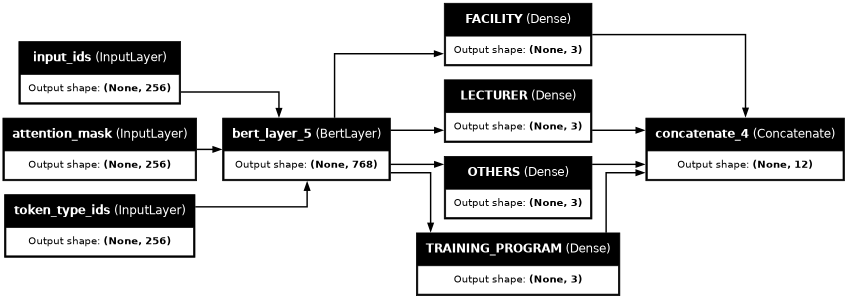

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file='architecture.png', rankdir='LR', dpi=52, show_shapes=True, show_layer_names=True)

# Prediction

In [68]:
y_pred = model.predict(test_dataset)

198/198 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step


In [92]:
y_test[200]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [128]:
np.argmax(np.reshape(y_test[919], (-1, 12)))

3

In [127]:
test_df['Sentence'][919]

'truyền đạt tốt '

In [126]:
np.reshape(y_pred[919], (-1, 3))

array([[0.3732398 , 0.27342805, 0.3533322 ],
       [0.6369971 , 0.30763423, 0.05536861],
       [0.28067762, 0.42252466, 0.29679775],
       [0.40234596, 0.15243833, 0.4452158 ]], dtype=float32)

In [86]:
# Lấy chỉ mục của giá trị lớn nhất trong mỗi hàng của mảng one-hot dự đoán
predicted_indices = np.argmax(y_pred[200], axis=-1)
predicted_indices

4

In [87]:
predicted_indices = max(np.argmax(np.reshape(y_test[200], (-1, 12)), axis=-1))
predicted_indices

10

In [88]:
def prediction(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    return y_pred

In [129]:
def print_pred(sentence_pred):
    print(sentence_pred)
    replacements = {0: 'positive', 1: 'negative', 2: 'neutral'}
    categories = test_df.columns[1:]
    topic1 = [0,1,2]
    topic2 = [3,4,5]
    topic3 = [6,7,8]
    topic4 = [9,10,11]
    index, probability = np.argmax(sentence_pred, axis=-1), np.max(sentence_pred, axis=-1)
    if index in topic1:
        category = categories[0]
        sentiment = replacements[index % 3]
    elif index in topic2:
        category = categories[1]
        sentiment = replacements[index % 3]
    elif index in topic3:
        category = categories[2]
        sentiment = replacements[index % 3]
    elif index in topic4:
        category = categories[3]
        sentiment = replacements[index % 3]
    print(f'=> {category},{sentiment} with probability: {probability}')

In [148]:
def print_test(y_test):
    print(y_test)
    replacements = {0: 'positive', 1: 'negative', 2: 'neutral'}
    categories = test_df.columns[1:]
    count = 0
    for i in y_test:
        topic = categories[count]
        sentiment = None
        if (i == [1, 0, 0]).all():
            sentiment = replacements[0]
        elif (i == [0, 1, 0]).all():
            sentiment = replacements[1]
        elif (i == [0, 0, 1]).all():
            sentiment = replacements[2]
        print(f'=> {topic}, {sentiment}')
        count += 1

## Predict on test data

In [151]:
for i in range(100,110):
    print('Example:', test_df['Sentence'][i])
    print()
    print("Prediction")
    print_pred(y_pred[i])
    print()
    print("Test")
    print_test(y_test[i])
    print()

Example: bài giảng hay và dễ hiểu 

Prediction
[0.38151595 0.26455528 0.35392877 0.8697264  0.0951203  0.03515321
 0.3441796  0.3511901  0.30463025 0.5815331  0.28123662 0.13723037]
=> LECTURER,positive with probability: 0.8697264194488525

Test
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]]
=> FACILITY, None
=> LECTURER, None
=> OTHERS, None
=> TRAINING_PROGRAM, positive

Example: thầy truyền đạt tốt 

Prediction
[0.31995374 0.3778985  0.3021477  0.7837889  0.20217621 0.01403499
 0.3747176  0.2968795  0.32840288 0.37623024 0.16941175 0.45435798]
=> LECTURER,positive with probability: 0.7837889194488525

Test
[[0 0 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]]
=> FACILITY, None
=> LECTURER, positive
=> OTHERS, None
=> TRAINING_PROGRAM, None

Example: đồ án phần bắt buộc chỉ chiếm 1dot5 điểm và chỉ biết sau khi đã nộp 

Prediction
[0.28878722 0.42877486 0.28243792 0.1190343  0.49972424 0.38124147
 0.32856402 0.30619308 0.3652429  0.20755842 0.58121705 0.2112245 ]
=> TRAINING_PROGRAM,negative with probability: 0

# Report

In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import numpy as np

def determine_sentiment(sentiment_index):
    if sentiment_index % 3 == 0:
        return 'positive'
    elif sentiment_index % 3 == 1:
        return 'negative'
    elif sentiment_index % 3 == 2:
        return 'neutral'

def determine_topic(topic_index):
    # Xác định chủ đề dựa trên chỉ số
    if topic_index in [0, 1, 2]:
        return 'FACILITY'
    elif topic_index in [3, 4, 5]:
        return 'LECTURER'
    elif topic_index in [6, 7, 8]:
        return 'OTHERS'
    elif topic_index in [9, 10, 11]:
        return 'TRAINING_PROGRAM'

def custom_accuracy(y_true, y_pred):
    # Tính toán accuracy theo logic của bạn
    true_indices = []
    pred_indices = []
    for i in range(len(y_true)):
        true_indices.append(max(np.argmax(np.reshape(y_true[i], (-1, 12)), axis=-1)))
    for i in range(len(y_pred)):
        pred_indices.append(np.argmax(y_pred[i], axis=-1))
        
    correct_predictions = 0
    total_predictions = len(y_true)
    for true_index, pred_index in zip(true_indices, pred_indices):
        if true_index == pred_index and true_index % 3 == pred_index % 3:
            correct_predictions += 1
    
    return correct_predictions / total_predictions


acc = custom_accuracy(y_test, y_pred)
print("Custom Accuracy:", acc)

true_indices = []
pred_indices = []
for i in range(len(y_test)):
    true_indices.append(max(np.argmax(np.reshape(y_test[i], (-1, 12)), axis=-1)))
for i in range(len(y_pred)):
    pred_indices.append(np.argmax(y_pred[i], axis=-1))

true_topics = [true_index // 3 for true_index in true_indices]
pred_topics = [pred_index // 3 for pred_index in pred_indices]

report = classification_report(true_topics, pred_topics)

# In ra báo cáo
print("Classification Report for Topics:")
print(report)

Custom Accuracy: 0.7163613392293114
Classification Report for Topics:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       145
           1       0.85      0.93      0.89      2290
           2       0.50      0.03      0.05       159
           3       0.62      0.55      0.58       572

    accuracy                           0.81      3166
   macro avg       0.67      0.56      0.56      3166
weighted avg       0.78      0.81      0.78      3166



In [153]:
# Tính toán true sentiments và predicted sentiments
true_sentiments = [determine_sentiment(index) for index in true_indices]
pred_sentiments = [determine_sentiment(index) for index in pred_indices]

# Tạo báo cáo phân loại cho sentiment
report_sentiment = classification_report(true_sentiments, pred_sentiments)

# In ra báo cáo phân loại cho sentiment
print("Classification Report for Sentiment:")
print(report_sentiment)

Classification Report for Sentiment:
              precision    recall  f1-score   support

    negative       0.84      0.90      0.87      1409
     neutral       0.62      0.09      0.16       167
    positive       0.88      0.89      0.89      1590

    accuracy                           0.86      3166
   macro avg       0.78      0.63      0.64      3166
weighted avg       0.85      0.86      0.84      3166



In [154]:
def combine_topic_sentiment(true_indices, pred_indices):
    true_topics = [determine_topic(index) for index in true_indices]
    pred_topics = [determine_topic(index) for index in pred_indices]
    true_sentiments = [determine_sentiment(index) for index in true_indices]
    pred_sentiments = [determine_sentiment(index) for index in pred_indices]
    
    true_combined = [f"{topic},{sentiment}" for topic, sentiment in zip(true_topics, true_sentiments)]
    pred_combined = [f"{topic},{sentiment}" for topic, sentiment in zip(pred_topics, pred_sentiments)]
    
    return true_combined, pred_combined

In [161]:
# Kết hợp chủ đề và cảm xúc
true_combined, pred_combined = combine_topic_sentiment(true_indices, pred_indices)

# Tạo báo cáo phân loại kết hợp
report_combined = classification_report(true_combined, pred_combined)

report_combined1 = classification_report(true_combined, pred_combined, output_dict=True)

# In ra báo cáo phân loại kết hợp
print("Combined Classification Report:")
print(report_combined)

Combined Classification Report:
                           precision    recall  f1-score   support

        FACILITY,negative       0.69      0.75      0.72       138
         FACILITY,neutral       0.00      0.00      0.00         2
        FACILITY,positive       0.00      0.00      0.00         5
        LECTURER,negative       0.67      0.74      0.70       791
         LECTURER,neutral       0.12      0.03      0.04        74
        LECTURER,positive       0.81      0.91      0.86      1425
          OTHERS,negative       0.00      0.00      0.00        64
           OTHERS,neutral       0.17      0.02      0.04        44
          OTHERS,positive       0.00      0.00      0.00        51
TRAINING_PROGRAM,negative       0.55      0.66      0.60       416
 TRAINING_PROGRAM,neutral       0.00      0.00      0.00        47
TRAINING_PROGRAM,positive       0.00      0.00      0.00       109

                 accuracy                           0.72      3166
                macro avg   

In [162]:
# Lấy các giá trị macro avg và weighted avg
macro_precision = report_combined1['macro avg']['precision']
macro_recall = report_combined1['macro avg']['recall']
macro_f1 = report_combined1['macro avg']['f1-score']

weighted_precision = report_combined1['weighted avg']['precision']
weighted_recall = report_combined1['weighted avg']['recall']
weighted_f1 = report_combined1['weighted avg']['f1-score']

# In các chỉ số tổng hợp
print("Macro Average Precision:", macro_precision)
print("Macro Average Recall:", macro_recall)
print("Macro Average F1-score:", macro_f1)

print("Weighted Average Precision:", weighted_precision)
print("Weighted Average Recall:", weighted_recall)
print("Weighted Average F1-score:", weighted_f1)

Macro Average Precision: 0.2508511228955243
Macro Average Recall: 0.2590136609358387
Macro Average F1-score: 0.2468428281849863
Weighted Average Precision: 0.6381846009397063
Weighted Average Recall: 0.7163613392293114
Weighted Average F1-score: 0.6731703027417464


In [157]:
example_input = text_preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}
pred = prediction(reloaded_model, tf.data.Dataset.from_tensor_slices(features))
print_pred(pred[0])

Enter your sentence:  chương trình học khá nặng nề, không áp dụng thực hành 


[0.3141796  0.3681108  0.31770954 0.25974542 0.587034   0.15322065
 0.34898582 0.36641327 0.2846009  0.25083515 0.6569121  0.09225272]
=> TRAINING_PROGRAM,negative with probability: 0.656912088394165
